In [1]:
import datetime
import importlib

import matplotlib.pyplot as plt
import pandas as pd
import pyadcirc.data.noaa as noaa

In [2]:
%matplotlib ipympl

In [3]:
importlib.reload(noaa)

<module 'pyadcirc.data.noaa' from '/home/jovyan/work/repos/pyadcirc/src/pyadcirc/data/noaa.py'>

# NOAA Library Basics

## Getting list of stations

In [4]:
noaa.NOAA_STATIONS

,Region,ID,Name
0,Alabama,8732828,"Weeks Bay, Mobile Bay"
1,Alabama,8735180,"Dauphin Island, AL"
2,Alabama,8735391,"Dog River Bridge, AL"
3,Alabama,8735523,"East Fowl River Bridge, AL"
4,Alabama,8736897,"Coast Guard Sector Mobile, AL"
...,...,...,...
289,Washington,9445958,"Bremerton, WA"
290,Washington,9446484,"Tacoma, WA"
291,Washington,9447130,"Seattle, WA"
292,Washington,9449424,"Cherry Point, WA"


Filtering by region

In [5]:
ak_stations = noaa.NOAA_STATIONS[noaa.NOAA_STATIONS["Region"] == "Alaska"]
ak_stations

,Region,ID,Name
9,Alaska,9450460,"Ketchikan, AK"
10,Alaska,9451054,"Port Alexander, AK"
11,Alaska,9451600,"Sitka, AK"
12,Alaska,9452210,"Juneau, AK"
13,Alaska,9452400,"Skagway, Taiya Inlet, AK"
14,Alaska,9452634,"Elfin Cove, AK"
15,Alaska,9453220,"Yakutat, Yakutat Bay, AK"
16,Alaska,9454050,"Cordova, AK"
17,Alaska,9454240,"Valdez, AK"
18,Alaska,9455090,"Seward, AK"


Can also use the cli:

In [3]:
!noaa_data --help

Usage: noaa_data [OPTIONS] COMMAND [ARGS]...

  Commands for interacting with the NOAA API

Options:
  --help  Show this message and exit.

Commands:
  find-events  Find storm surge events
  get          Get a product over a date range at particular station:
  info         Info on available products
  stations     Info on available products


In [88]:
!noaa_data stations -r Alaska

    _   ______  ___    ___       __________        ____  ____  _____
   / | / / __ \/   |  /   |     / ____/ __ \      / __ \/ __ \/ ___/
  /  |/ / / / / /| | / /| |    / /   / / / /_____/ / / / /_/ /\__ \ 
 / /|  / /_/ / ___ |/ ___ |   / /___/ /_/ /_____/ /_/ / ____/___/ / 
/_/ |_/\____/_/  |_/_/  |_|   \____/\____/      \____/_/    /____/  
                                                                    

See https://tidesandcurrents.noaa.gov/ for more on stations and available products at each.
+---------+----------------------------------+--------+
|    ID   |               Name               | Region |
+---------+----------------------------------+--------+
| 9450460 |          Ketchikan, AK           | Alaska |
| 9451054 |        Port Alexander, AK        | Alaska |
| 9451600 |            Sitka, AK             | Alaska |
| 9452210 |            Juneau, AK            | Alaska |
| 9452400 |     Skagway, Taiya Inlet, AK     | Alaska |
| 9452634 |          Elfin Cove, AK          

## Getting station metadata

In [89]:
# pandas dataframe - index using iloc if not searching on index key
first_station = ak_stations.iloc[0]
first_station["ID"]

9450460

In [90]:
noaa.get_station_metadata(int(first_station["ID"]))

{'name': 'Ketchikan', 'id': 9450460, 'coords': [228.373889, 55.331944]}

In [4]:
!noaa_data get -p metadata 9450460

    _   ______  ___    ___       __________        ____  ____  _____
   / | / / __ \/   |  /   |     / ____/ __ \      / __ \/ __ \/ ___/
  /  |/ / / / / /| | / /| |    / /   / / / /_____/ / / / /_/ /\__ \ 
 / /|  / /_/ / ___ |/ ___ |   / /___/ /_/ /_____/ /_/ / ____/___/ / 
/_/ |_/\____/_/  |_/_/  |_|   \____/\____/      \____/_/    /____/  
                                                                    

id,name,Longitude,Latitude
9450460,Ketchikan,228.373889,55.331944


## Station URL

We can explore the station at the following link:

https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460

In [6]:
station_link = (
    f"https://tidesandcurrents.noaa.gov/stationhome.html?id={9450460}"
)
station_link

'https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460'

## Getting station data

Lets see the main function that does this:

In [7]:
nome = 9468756
noaa.get_station_metadata(nome)

{'name': 'Nome, Norton Sound',
 'id': 9468756,
 'coords': [194.560361, 64.494611]}

In [8]:
begin_date = "2022-09-01 00:00:00"
end_date = "2022-11-01 00:00:00"
nome_data = noaa.pull_dataset(nome, begin_date=begin_date, end_date=end_date)

In [9]:
nome_data

,Sigma,Water Level,Prediction
Date Time,,,
2022-09-01 00:00:00,0.012,0.425,0.011
2022-09-01 00:06:00,0.012,0.429,0.004
2022-09-01 00:12:00,0.013,0.420,-0.003
2022-09-01 00:18:00,0.010,0.408,-0.011
2022-09-01 00:24:00,0.015,0.400,-0.018
...,...,...,...
2022-10-31 23:30:00,0.004,0.177,0.021
2022-10-31 23:36:00,0.004,0.179,0.021
2022-10-31 23:42:00,0.005,0.174,0.021


<AxesSubplot: xlabel='Date Time'>

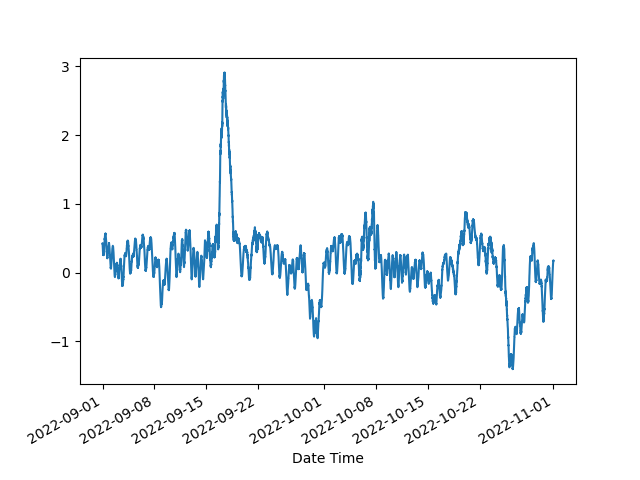

In [10]:
fig = plt.figure()
nome_data["Water Level"].plot()

## Wicks Algo Breakdown

In [11]:
data = nome_data.copy()
trigger_threshold = 1.0
continuity_threshold = 0.9

In [12]:
data.sort_index()
data["Date Time"] = data.index
continuity_threshold = continuity_threshold * trigger_threshold
data["Difference"] = abs(data["Prediction"] - data["Water Level"])
data["TriggerThreshold"] = data["Difference"].apply(lambda x: x > trigger_threshold)
data["ContinuityThreshold"] = data["Difference"].apply(
    lambda x: x > continuity_threshold
)
data["Group"] = data["TriggerThreshold"].ne(data["TriggerThreshold"].shift()).cumsum()
data

,Sigma,Water Level,Prediction,Date Time,Difference,TriggerThreshold,ContinuityThreshold,Group
Date Time,,,,,,,,
2022-09-01 00:00:00,0.012,0.425,0.011,2022-09-01 00:00:00,0.414,False,False,1
2022-09-01 00:06:00,0.012,0.429,0.004,2022-09-01 00:06:00,0.425,False,False,1
2022-09-01 00:12:00,0.013,0.420,-0.003,2022-09-01 00:12:00,0.423,False,False,1
2022-09-01 00:18:00,0.010,0.408,-0.011,2022-09-01 00:18:00,0.419,False,False,1
2022-09-01 00:24:00,0.015,0.400,-0.018,2022-09-01 00:24:00,0.418,False,False,1
...,...,...,...,...,...,...,...,...
2022-10-31 23:30:00,0.004,0.177,0.021,2022-10-31 23:30:00,0.156,False,False,7
2022-10-31 23:36:00,0.004,0.179,0.021,2022-10-31 23:36:00,0.158,False,False,7
2022-10-31 23:42:00,0.005,0.174,0.021,2022-10-31 23:42:00,0.153,False,False,7


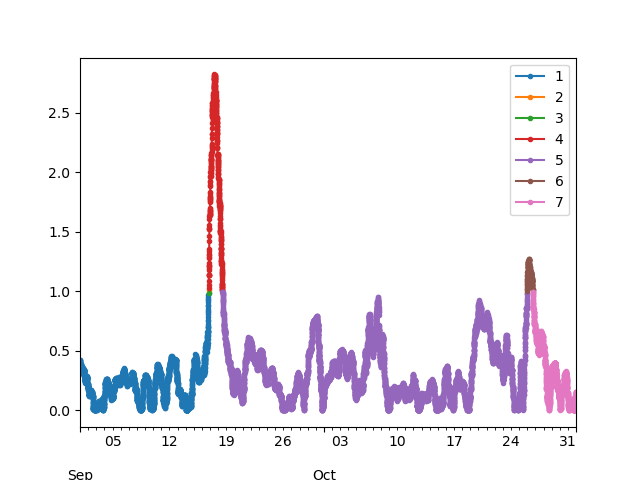

In [13]:
fig = plt.figure()
for g in data.groupby("Group"):
    g[1]["Difference"].plot(marker=".", label=f"{g[0]}")
    # if g[0] == 2:
    # g[1]['Difference'].plot(marker='o', label=f'{g[0]}')
plt.legend()

### Summary of method

1. True false flag if residual level above trigger threshold (T).
2. Create groups between each switch between over/under threshold
3. Each under-threshold group Group is joined with surrounding groups if:

    a. **Lull period (L)** - If duration of group less than "lull" duration L. Default = 6h = 21600s.
    
    b. **Continuation threshold (C)** - If values in the group do not drop below secondary "continuity" threshold C, usually specified as a ratio of the target threshold. Default = 0.9T.
    
   Else the grouping is considered to be a separator between distinct events.
   
4. For each found grouping:

    a. **Shoulder Rule (S)** - include time periods before and after event - Include data S hours before and after identified event (measured by crossing of continuity threshold). Default = 12h = 43200s
    
    b. **Chute Rule (R)** - Include water levels that are below thresholds but considered part of onset and return of surge event -> So include R steps before and after storm surge event (after dropping below continuity threshold). Default = 9.

In [22]:
trigger_thresold = 1.0
continuity_thresold = 0.9
lull_duration = 21600
shoulder_period = 43200
chute_rule = 9

In [23]:
events = noaa.wicks_2017_algo(nome_data, trigger_threshold=trigger_threshold, lull_duration=lull_duration, continuity_threshold=continuity_thresold, shoulder_period=shoulder_period, chute_rule=chute_rule, interactive=False)

len(events), events[0][0:5][["Water Level", "Prediction", "Difference"]]

(2,
                      Water Level  Prediction  Difference
 Date Time                                               
 2022-09-16 06:30:00        0.471       0.054       0.417
 2022-09-16 06:36:00        0.483       0.060       0.423
 2022-09-16 06:42:00        0.495       0.066       0.429
 2022-09-16 06:48:00        0.529       0.072       0.457
 2022-09-16 06:54:00        0.520       0.077       0.443)

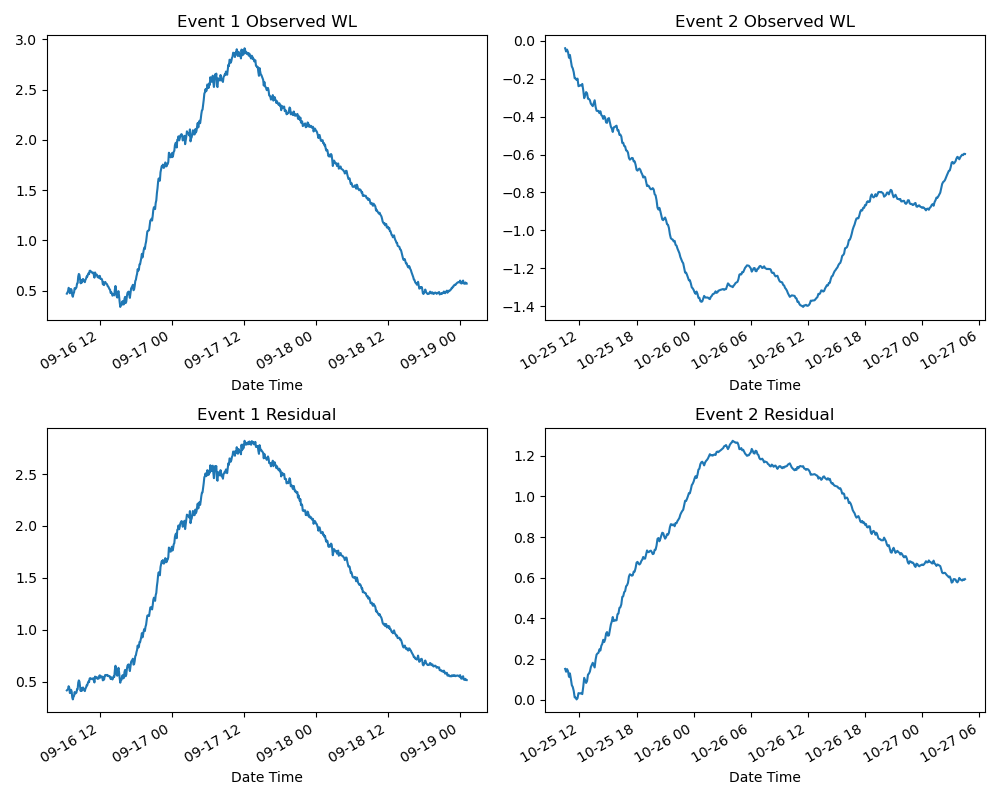

In [24]:
fig = plt.figure(figsize=(10, 8))

for i, e in enumerate(events):
    ax = fig.add_subplot(2, len(events), i + 1)
    e["Water Level"].plot(ax=ax)
    ax.set_title(f"Event {i+1} Observed WL")
    ax = fig.add_subplot(2, len(events), 2 + i + 1)
    e["Difference"].plot(ax=ax)
    ax.set_title(f"Event {i+1} Residual")

fig.tight_layout()

In [25]:
events = noaa.wicks_2017_algo(nome_data, trigger_threshold=1.0, interactive=True)

Storm Surge Event Found (18.9H) :                                                                   
Time:2022-09-16T11:18:00.000000000 - 2022-09-19T00:42:00.000000000                                  
 2.820m ┼                             ╭────╮
 2.538m ┤                      ╭──────╯    ╰─────╮
 2.256m ┤                    ╭─╯                 ╰──╮
 1.974m ┤                ╭───╯                      ╰────╮
 1.692m ┤             ╭──╯                               ╰────╮
 1.410m ┤           ╭─╯                                       ╰───╮
 1.128m ┤─────────╭─╯─────────────────────────────────────────────╰───╮─────────────────
 0.846m ┤────────╭╯───────────────────────────────────────────────────╰──────╮──────────
 0.564m ┤────────╯                                                           ╰───────
 0.282m ┤
 0.000m ┼───────────────────────────────────────────────────────────────────────────────




 ==== Keep event? (Y/N) ==== 
 T


Storm Surge Event Found (18.3H) :                                                                   
Time:2022-10-25T14:00:00.000000000 - 2022-10-27T04:18:00.000000000                                  
 1.265m ┼                        ╭────────╮
 1.138m ┤                    ╭───╯        ╰──────────────╮
 1.012m ┤─────────────────╭──╯───────────────────────────╰────╮─────────────────────────
 0.885m ┤──────────────╭──╯───────────────────────────────────╰────╮────────────────────
 0.759m ┤         ╭────╯                                           ╰─────╮
 0.632m ┤      ╭──╯                                                      ╰───────────
 0.506m ┤    ╭─╯
 0.380m ┤  ╭─╯
 0.253m ┤──╯
 0.126m ┤
 0.000m ┼───────────────────────────────────────────────────────────────────────────────




 ==== Keep event? (Y/N) ==== 
 Y


## Large Date Range

In [26]:
import importlib

importlib.reload(noaa)

<module 'pyadcirc.data.noaa' from '/home/jovyan/work/repos/pyadcirc/src/pyadcirc/data/noaa.py'>

In [27]:
begin_date = pd.to_datetime("19790101 00:00")
end_date = pd.to_datetime("20230101 00:01")

In [ ]:
nome_data_01_23 = noaa.pull_dataset(nome, begin_date=begin_date, end_date=end_date)

In [30]:
nome_data_full = nome_data_01_23.dropna()
nome_data_full

,Sigma,Water Level,Prediction
Date Time,,,
1992-10-01 03:00:00,0.000,-0.211,-0.131
1992-10-01 03:06:00,0.000,-0.201,-0.127
1992-10-01 03:12:00,0.000,-0.190,-0.123
1992-10-01 03:18:00,0.000,-0.179,-0.119
1992-10-01 03:24:00,0.000,-0.168,-0.114
...,...,...,...
2022-12-31 23:36:00,0.002,0.256,0.215
2022-12-31 23:42:00,0.002,0.247,0.216
2022-12-31 23:48:00,0.002,0.244,0.218


In [25]:
events = noaa.wicks_2017_algo(nome_data_01_23, trigger_threshold=1.0, interactive=False)

In [26]:
len(events), events[0]

(191,
                      Sigma  Water Level  Prediction  Difference  \
 Date Time                                                         
 2001-01-05 23:48:00    0.0       -0.229       0.168       0.397   
 2001-01-05 23:54:00    0.0       -0.230       0.170       0.400   
 2001-01-06 00:00:00    0.0       -0.235       0.171       0.406   
 2001-01-06 00:06:00    0.0       -0.234       0.172       0.406   
 2001-01-06 00:12:00    0.0       -0.240       0.173       0.413   
 ...                    ...          ...         ...         ...   
 2001-01-08 19:24:00    0.0       -0.115       0.076       0.191   
 2001-01-08 19:30:00    0.0       -0.111       0.073       0.184   
 2001-01-08 19:36:00    0.0       -0.107       0.070       0.177   
 2001-01-08 19:42:00    0.0       -0.108       0.067       0.175   
 2001-01-08 19:48:00    0.0       -0.109       0.065       0.174   
 
                      TriggerThreshold  ContinuityThreshold  Group  \
 Date Time                            

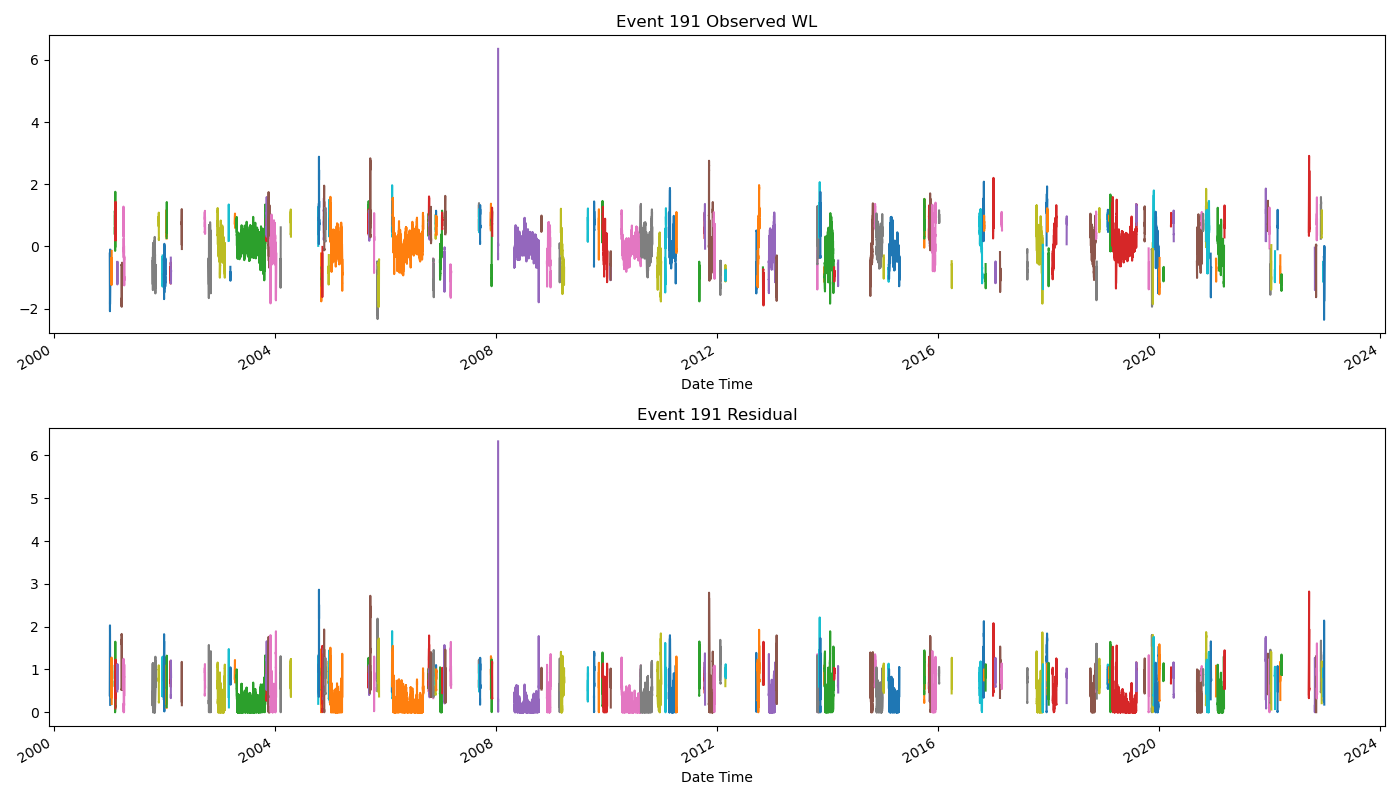

In [27]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ne = len(events)
for i, e in enumerate(events[0:ne]):
    e["Water Level"].plot(ax=ax1)
    e["Difference"].plot(ax=ax2)

ax1.set_title(f"Event {i+1} Observed WL")
ax2.set_title(f"Event {i+1} Residual")

fig.tight_layout()

In [60]:
ak_stations = noaa.NOAA_STATIONS[noaa.NOAA_STATIONS["Region"] == "Alaska"]
ak_stations

,Region,ID,Name
9,Alaska,9450460,"Ketchikan, AK"
10,Alaska,9451054,"Port Alexander, AK"
11,Alaska,9451600,"Sitka, AK"
12,Alaska,9452210,"Juneau, AK"
13,Alaska,9452400,"Skagway, Taiya Inlet, AK"
14,Alaska,9452634,"Elfin Cove, AK"
15,Alaska,9453220,"Yakutat, Yakutat Bay, AK"
16,Alaska,9454050,"Cordova, AK"
17,Alaska,9454240,"Valdez, AK"
18,Alaska,9455090,"Seward, AK"


# Alaska Stations

## 9468756	Nome , AK

In [31]:
nome = 9468756
noaa.get_station_metadata(nome), (f"https://tidesandcurrents.noaa.gov/stationhome.html?id={nome}")

({'name': 'Nome, Norton Sound',
  'id': 9468756,
  'coords': [194.560361, 64.494611]},
 'https://tidesandcurrents.noaa.gov/stationhome.html?id=9468756')

In [27]:
begin_date = pd.to_datetime("19790101 00:00")
end_date = pd.to_datetime("20230101 00:01")

In [ ]:
nome_data_full = noaa.pull_dataset(nome, begin_date=begin_date, end_date=end_date)

In [52]:
nome_data_full = nome_data_full.dropna()
nome_data_full

,Sigma,Water Level,Prediction,Difference,TriggerThreshold,ContinuityThreshold,Group
Date Time,,,,,,,
1992-10-01 03:00:00,0.000,-0.211,-0.131,0.080,False,False,1
1992-10-01 03:06:00,0.000,-0.201,-0.127,0.074,False,False,1
1992-10-01 03:12:00,0.000,-0.190,-0.123,0.067,False,False,1
1992-10-01 03:18:00,0.000,-0.179,-0.119,0.060,False,False,1
1992-10-01 03:24:00,0.000,-0.168,-0.114,0.054,False,False,1
...,...,...,...,...,...,...,...
2022-12-31 23:36:00,0.002,0.256,0.215,0.041,False,False,2777
2022-12-31 23:42:00,0.002,0.247,0.216,0.031,False,False,2777
2022-12-31 23:48:00,0.002,0.244,0.218,0.026,False,False,2777


In [33]:
trigger_thresold = 1.0
continuity_thresold = 0.9
lull_duration = 21600
shoulder_period = 43200
chute_rule = 9

In [54]:
importlib.reload(noaa)

<module 'pyadcirc.data.noaa' from '/home/jovyan/work/repos/pyadcirc/src/pyadcirc/data/noaa.py'>

> /home/jovyan/work/repos/pyadcirc/src/pyadcirc/data/noaa.py(580)wicks_2017_algo()
    578 
    579             # Add shoulder period
--> 580             shoulder_timesteps = int(
    581                 pd.to_timedelta(shoulder_period, "S") /
    582                 pd.to_timedelta(6, "m"))



ipdb>  found_idxs


array([ 77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 25

ipdb>  data


                     Sigma  Water Level  Prediction  Difference  \
Date Time                                                         
1992-10-01 03:00:00  0.000       -0.211      -0.131       0.080   
1992-10-01 03:06:00  0.000       -0.201      -0.127       0.074   
1992-10-01 03:12:00  0.000       -0.190      -0.123       0.067   
1992-10-01 03:18:00  0.000       -0.179      -0.119       0.060   
1992-10-01 03:24:00  0.000       -0.168      -0.114       0.054   
...                    ...          ...         ...         ...   
2022-12-31 23:36:00  0.002        0.256       0.215       0.041   
2022-12-31 23:42:00  0.002        0.247       0.216       0.031   
2022-12-31 23:48:00  0.002        0.244       0.218       0.026   
2022-12-31 23:54:00  0.001        0.249       0.218       0.031   
2023-01-01 00:00:00  0.001        0.249       0.219       0.030   

                     TriggerThreshold  ContinuityThreshold  Group  
Date Time                                                   

ipdb>  plt.figure(); data['Difference'].loc[found_idxs].plot()


*** NameError: name 'plt' is not defined


ipdb>  import matplotlib.pyplot as plt
ipdb>  plt.figure(); data['Difference'].loc[found_idxs].plot()


<Figure size 640x480 with 0 Axes>
*** KeyError: "None of [Int64Index([ 77,  78,  79,  80,  81,  82,  83,  84,  85,  86,\n            ...\n            723, 724, 725, 726, 727, 728, 729, 730, 731, 732],\n           dtype='int64', name='Date Time', length=656)] are in the [index]"


ipdb>  plt.figure(); data['Difference'][found_idxs].plot()


<Figure size 640x480 with 0 Axes>
<AxesSubplot: xlabel='Date Time'>


ipdb>  plt.show()


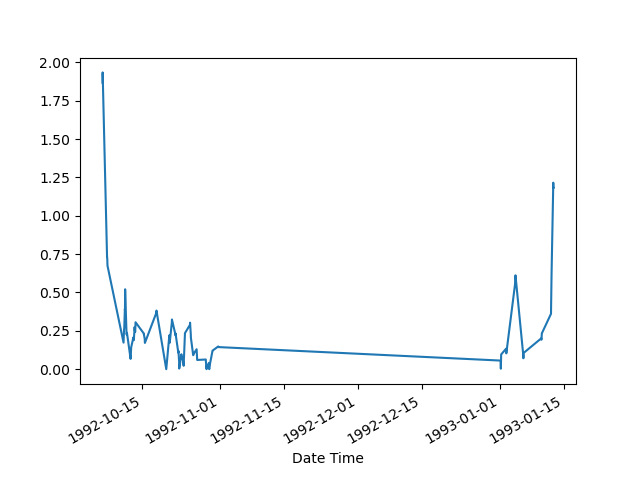

ipdb>  q


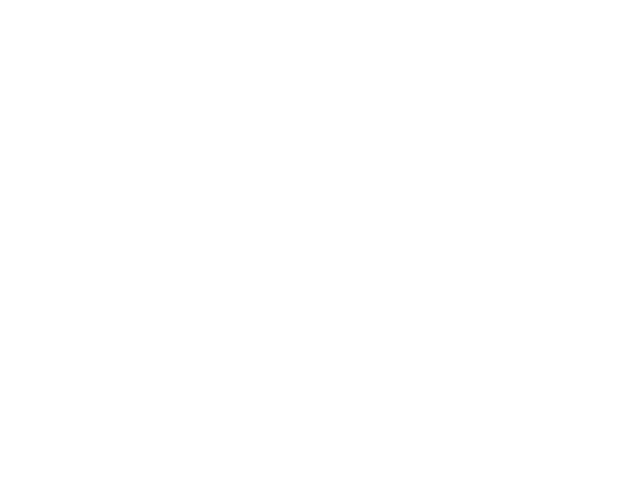

In [55]:
nome_events_1 = noaa.wicks_2017_algo(
    nome_data_full,
    end_date = 
    trigger_threshold=trigger_threshold,
    lull_duration=lull_duration,
    continuity_threshold=continuity_thresold,
    shoulder_period=shoulder_period,
    chute_rule=chute_rule,
    interactive=False,
)

len(nome_events_1), nome_events_1[0][0:5][["Water Level", "Prediction", "Difference"]]

In [ ]:
#### Plotting Events

In [44]:
import numpy as np 
num_plot = len(nome_events_1)
event_step = int(len(nome_events_1)/num_plot)
to_plot = np.arange(0, len(nome_events_1)-1, event_step)

<AxesSubplot: xlabel='Date Time'>

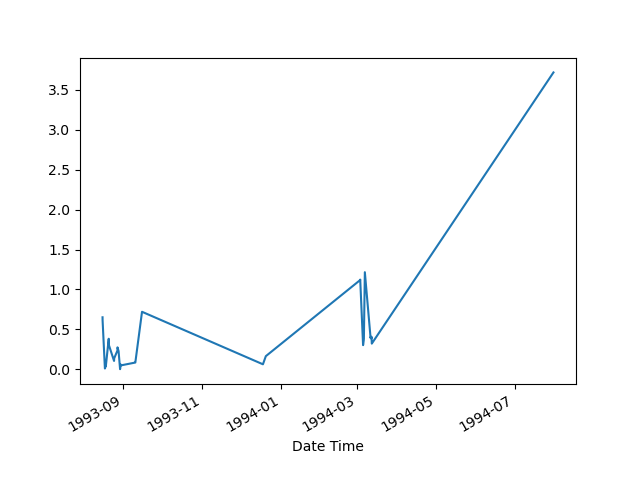

In [57]:
fig = plt.figure()
nome_events_1[1]['Difference'].plot()

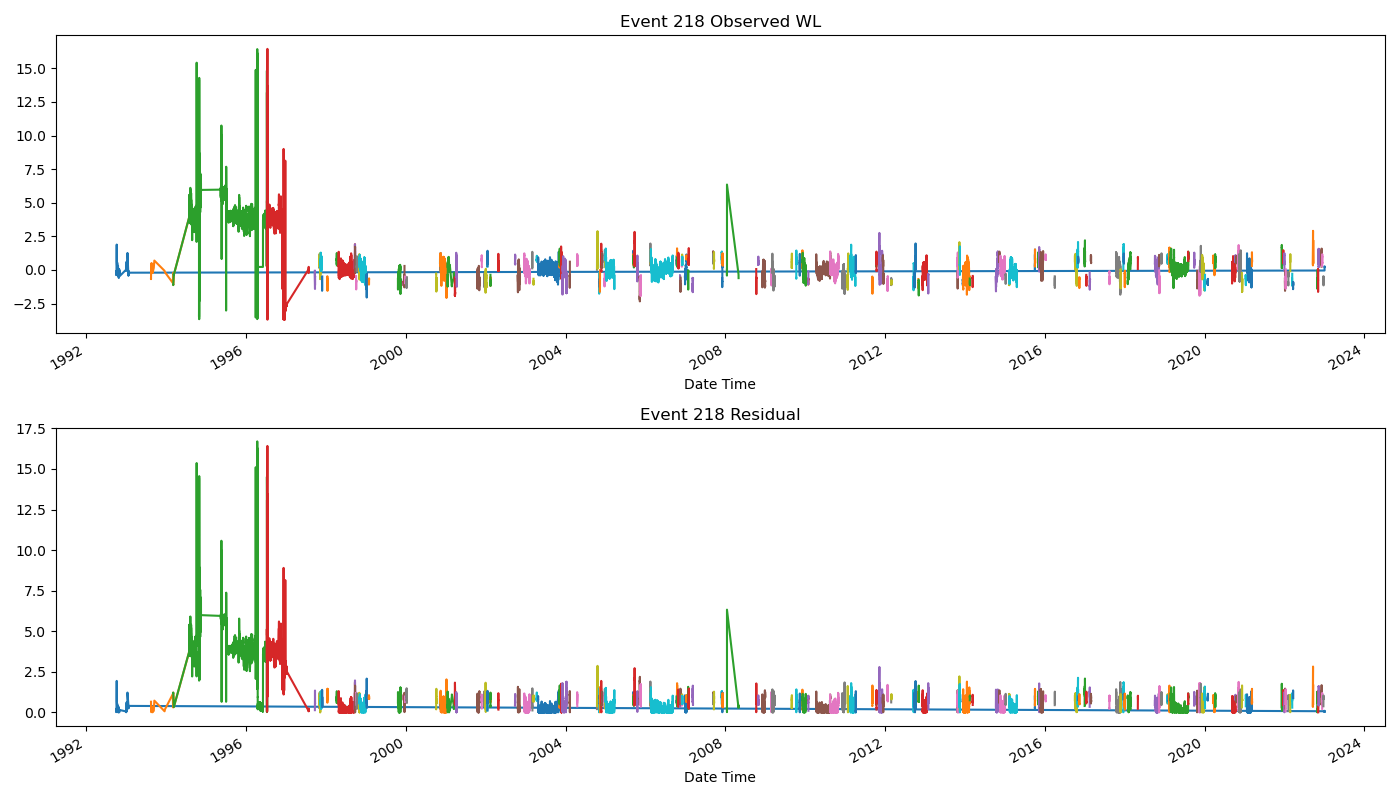

In [45]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ne = len(events)
for i in to_plot:
    nome_events_1[i]["Water Level"].plot(ax=ax1)
    nome_events_1[i]["Difference"].plot(ax=ax2)

ax1.set_title(f"Event {i+1} Observed WL")
ax2.set_title(f"Event {i+1} Residual")

fig.tight_layout()

## 9450460	Ketchikan, AK


In [63]:
ketchikan = 9450460
(f"https://tidesandcurrents.noaa.gov/stationhome.html?id={ketchikan}")

'https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460'

In [ ]:
begin_date = "1990-07-01 00:00:00"
end_date = "2023-01-01 00:00:00"
ketchikan_data = noaa.pull_dataset(ketchikan, begin_date=begin_date, end_date=end_date)
ketchikan_data

In [65]:
ketchikan_data.to_csv("9450460_full_raw.csv")

In [75]:
kd = pd.read_csv("9450460_full_raw.csv")
kd = ketchikan_data.dropna()
kd

,Sigma,Water Level,Prediction,Difference,TriggerThreshold,ContinuityThreshold,Group
Date Time,,,,,,,
1995-01-30 15:00:00,0.022,0.451,0.309,0.142,False,False,1
1995-01-30 15:06:00,0.022,0.301,0.149,0.152,False,False,1
1995-01-30 15:12:00,0.024,0.141,-0.011,0.152,False,False,1
1995-01-30 15:18:00,0.024,-0.023,-0.172,0.149,False,False,1
1995-01-30 15:24:00,0.023,-0.187,-0.333,0.146,False,False,1
...,...,...,...,...,...,...,...
2022-12-31 23:30:00,0.018,-0.337,-0.358,0.021,False,False,1
2022-12-31 23:36:00,0.020,-0.395,-0.416,0.021,False,False,1
2022-12-31 23:42:00,0.019,-0.457,-0.472,0.015,False,False,1


<AxesSubplot: xlabel='Date Time'>

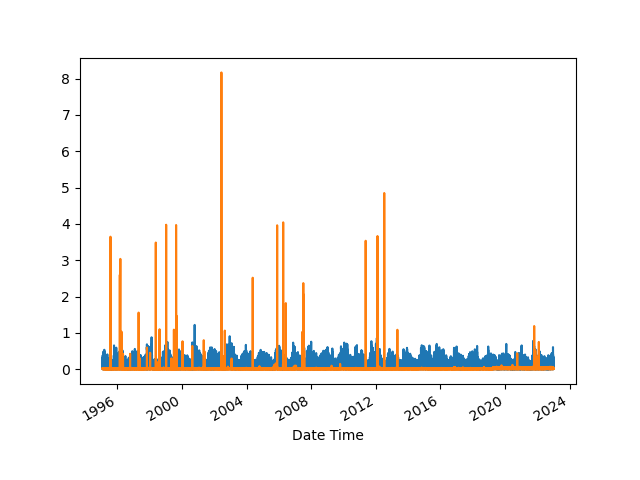

In [84]:
plt.figure()
kd["Difference"].plot()
kd["Sigma"].plot()

In [ ]:
events_05 = noaa.wicks_2017_algo(kd, trigger_threshold=0.75, interactive=True)

<AxesSubplot: xlabel='Date Time'>

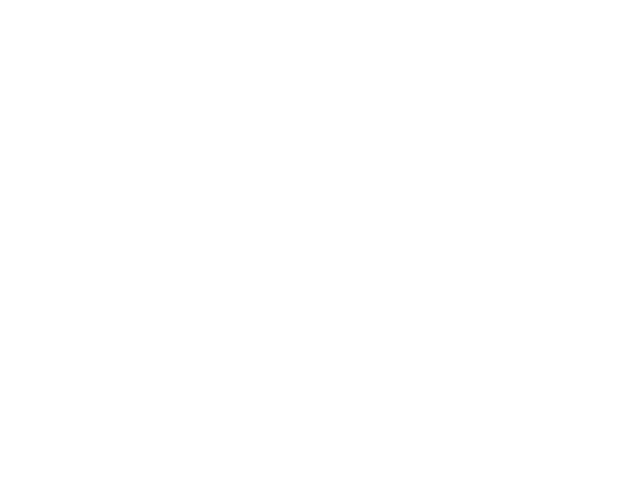

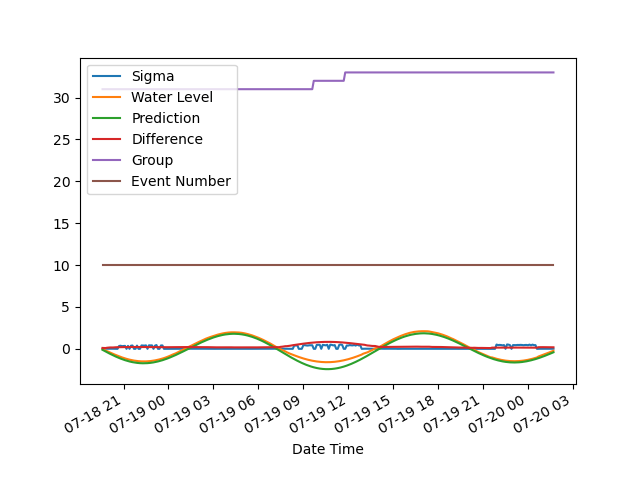

In [83]:
plt.figure()
events_05[10].plot()

## 9491094	Red Dog Dock, AK

In [29]:
rdd = 9491094
noaa.get_station_metadata(rdd)

{'name': 'Red Dog Dock', 'id': 9491094, 'coords': [195.935611, 67.575806]}

### Type A Event

<cite id="6bkc4"><a href="#zotero%7C11450669%2F7F6J6S7U">(Wicks &#38; Atkinson, 2017)</a></cite>

In [33]:
begin_date = "2008-01-01 00:00:00"
end_date = "2008-03-01 00:00:00"
rdd_test_data = noaa.pull_dataset(rdd, begin_date=begin_date, end_date=end_date)
rdd_test_data

,Sigma,Water Level,Prediction
Date Time,,,
2008-01-01 00:00:00,0.001,-0.439,-0.098
2008-01-01 00:06:00,0.001,-0.436,-0.101
2008-01-01 00:12:00,0.002,-0.437,-0.104
2008-01-01 00:18:00,0.004,-0.443,-0.107
2008-01-01 00:24:00,0.002,-0.457,-0.110
...,...,...,...
2008-02-29 23:30:00,0.004,-0.525,-0.174
2008-02-29 23:36:00,0.002,-0.527,-0.177
2008-02-29 23:42:00,0.004,-0.538,-0.179


<AxesSubplot: xlabel='Date Time'>

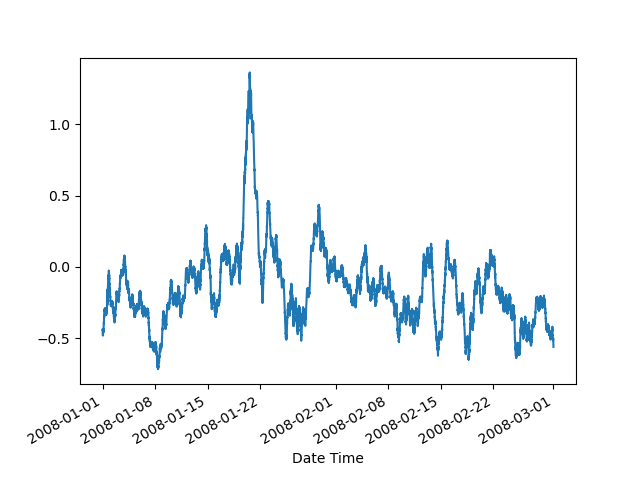

In [34]:
plt.figure()
rdd_test_data["Water Level"].plot()

In [35]:
events = noaa.wicks_2017_algo(rdd_test_data, trigger_threshold=1.0, interactive=False)

In [36]:
len(events)

1

<AxesSubplot: xlabel='Date Time'>

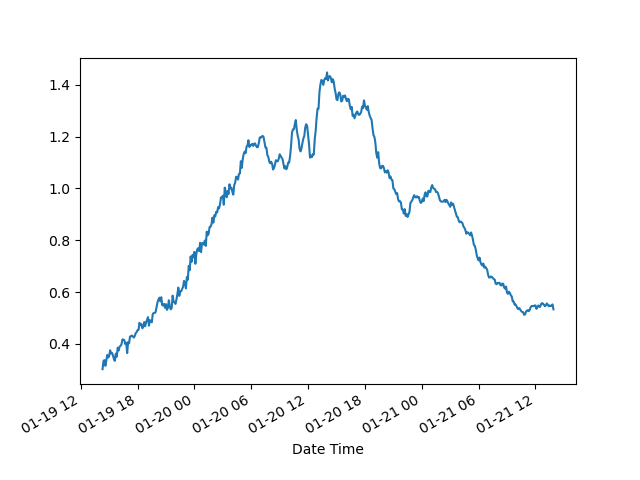

In [38]:
plt.figure()
events[0]["Difference"].plot()

# NCAR ds094.1 Range (2011-2022)

In [39]:
begin_date = "2011-01-01 00:00:00"
end_date = "2023-01-01 00:00:00"
rdd_data = noaa.pull_dataset(rdd, begin_date=begin_date, end_date=end_date)
rdd_data

on 150: {'station': 9491094, 'product': 'water_level', 'datum': 'msl', 'units': 'metric', 'time_zone': 'lst_ldt', 'format': 'csv', 'application': 'pyadcirc', 'begin_date': '20221129', 'end_date': '20221228'} generated no data
on 151: {'station': 9491094, 'product': 'water_level', 'datum': 'msl', 'units': 'metric', 'time_zone': 'lst_ldt', 'format': 'csv', 'application': 'pyadcirc', 'begin_date': '20221228', 'end_date': '20230126'} generated no data


,Sigma,Water Level,Prediction
Date Time,,,
2011-01-01 00:00:00,0.003,-0.161,0.007
2011-01-01 00:06:00,0.003,-0.158,0.002
2011-01-01 00:12:00,0.004,-0.164,-0.003
2011-01-01 00:18:00,0.004,-0.165,-0.008
2011-01-01 00:24:00,0.004,-0.154,-0.013
...,...,...,...
2022-11-27 00:30:00,0.009,0.225,0.017
2022-11-27 00:36:00,0.010,0.210,0.021
2022-11-27 00:42:00,0.015,0.247,0.025


In [40]:
rdd_data.dropna()

,Sigma,Water Level,Prediction
Date Time,,,
2011-01-01 00:00:00,0.003,-0.161,0.007
2011-01-01 00:06:00,0.003,-0.158,0.002
2011-01-01 00:12:00,0.004,-0.164,-0.003
2011-01-01 00:18:00,0.004,-0.165,-0.008
2011-01-01 00:24:00,0.004,-0.154,-0.013
...,...,...,...
2022-11-27 00:30:00,0.009,0.225,0.017
2022-11-27 00:36:00,0.010,0.210,0.021
2022-11-27 00:42:00,0.015,0.247,0.025


In [47]:
import importlib

importlib.reload(noaa)

<module 'pyadcirc.data.noaa' from '/home/jovyan/work/repos/pyadcirc/src/pyadcirc/data/noaa.py'>

In [48]:
begin_date = "2011-01-01 00:00:00"
end_date = "2023-01-01 00:00:00"
rdd_data = noaa.pull_dataset(rdd, begin_date=begin_date, end_date=end_date)
rdd_data

on 147: {'station': 9491094, 'product': 'water_level', 'datum': 'msl', 'units': 'metric', 'time_zone': 'lst_ldt', 'format': 'csv', 'application': 'pyadcirc', 'begin_date': '20221129', 'end_date': '20221228'} generated no data
on 148: {'station': 9491094, 'product': 'water_level', 'datum': 'msl', 'units': 'metric', 'time_zone': 'lst_ldt', 'format': 'csv', 'application': 'pyadcirc', 'begin_date': '20221228', 'end_date': '20230126'} generated no data


,Sigma,Water Level,Prediction
Date Time,,,
2011-01-01 00:00:00,0.003,-0.161,0.007
2011-01-01 00:06:00,0.003,-0.158,0.002
2011-01-01 00:12:00,0.004,-0.164,-0.003
2011-01-01 00:18:00,0.004,-0.165,-0.008
2011-01-01 00:24:00,0.004,-0.154,-0.013
...,...,...,...
2022-11-27 00:30:00,0.009,0.225,0.017
2022-11-27 00:36:00,0.010,0.210,0.021
2022-11-27 00:42:00,0.015,0.247,0.025


In [53]:
events_2 = noaa.wicks_2017_algo(rdd_data, trigger_threshold=2.0, interactive=True)

In [54]:
events_1 = noaa.wicks_2017_algo(rdd_data, trigger_threshold=1.0, interactive=False)
len(events_1)

35

<AxesSubplot: xlabel='Date Time'>

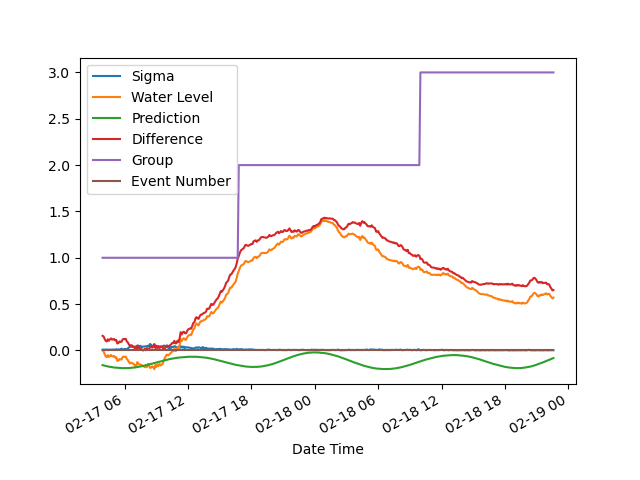

In [85]:
events_1[0].plot()